In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from skimage.transform import rotate

def get_kernel_size(image):
    # calculate kernel height and width based on the image size
    kernel_height = int(image.shape[0] / 80)
    kernel_width = int(image.shape[1] / 80)

    # ensure kernel height and width are odd numbers
    if kernel_height % 2 == 0:
        kernel_height += 1
    if kernel_width % 2 == 0:
        kernel_width += 1

    # return the kernel size
    return (kernel_width, kernel_height)

def barcode_detection(image_path,iter):
    # load the image and convert it to grayscale
    image = cv2.imread(image_path)
    #resize image
    image = cv2.resize(image,None,fx=0.7, fy=0.7, interpolation = cv2.INTER_CUBIC)

    #convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #calculate x & y gradient
    gradX = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
    gradY = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)
    gradient=np.sqrt(gradX**2+gradY**2)

    # blur the image
    blurred = cv2.blur(gradient, (3, 3))

    # threshold the image
    (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)

    # construct a closing kernel and apply it to the thresholded image
    kernel_width, kernel_height = get_kernel_size(thresh)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_width, kernel_height))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # perform a series of erosions and dilations
    closed = cv2.erode(closed, None, iterations = iter)
    closed = cv2.dilate(closed, None, iterations = iter)

    # find the contours in the thresholded image, then sort the contours
    # by their area, keeping only the largest one
    closed = closed.astype(np.uint8)
    cnts,hierarchy = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]

    # compute the rotated bounding box of the largest contour
    rect = cv2.minAreaRect(c)
    box = np.int0(cv2.boxPoints(rect))

    # draw a bounding box arounded the detected barcode and display the
    cv2.drawContours(image, [box], -1, (0, 255, 0), 3)

    # resize the image for displaying
    image = cv2.resize(image, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)

    return image


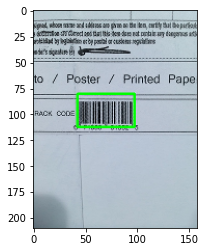

In [ ]:
image_path = "barcode_05.jpg"
result = barcode_detection(image_path,iter=20)
plt.imshow(result,cmap="gray")